#TODO's: 
1. Set up a virtual enviorment (conda or .venv) 
2. Set up the needed packages 
3. Analize the Dataset
4. look for classification Algorithm
5. Preporcess Dataset
6. Make sure CUDA works
7. Train model with the goal of high recall (because it's a dataset that needs to detect attacks)
8. Look at the performance

NOTE: some codes start with a #-***-
These codes were not included with the main output and training od the code. While training preprocessing categorical data was forgotten. But if it would be included the #-***- codes would be the codes to use. The codes contain encoding, and special feature extraction for the 3 categorical datas containing in the dataset. 

In [1]:
#Check GPU
!nvidia-smi

Tue Dec 17 22:26:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.03                 Driver Version: 566.03         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8              6W /   85W |      18MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#import the standard libraries for data analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import torch # To check GPU availability

# Import the libraries for deep learning - Neural Networks
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [3]:
# ML Libraries
from sklearn.model_selection import train_test_split, GridSearchCV # added for hyperparameter optimization
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    precision_recall_curve,
    f1_score,
    average_precision_score,
    recall_score,
    make_scorer,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer # added to impute missing values, SVC does not handle missing values so gotta fix that error

#-***-
import ipaddress  # For IP address processing

In [4]:
# Check for GPU availability 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Data Loading

In [5]:
# Load the dataset to df parameter
df = pd.read_csv('dataset_sdn.csv')

Data Analysis

In [16]:
# Basic information about the dataset
print("Dataset shape: ", df.shape) # rows - data, columns - features
print("\nClass Distribution:")
print(df['label'].value_counts(normalize=True)) # class distribution (0 - benign, 1 - malicious), how many % of each class

print("\nMissing values before cleaning:")
print(df.isnull().sum()) # missing values in the dataset



Dataset shape:  (104345, 23)

Class Distribution:
label
0    0.609143
1    0.390857
Name: proportion, dtype: float64

Missing values before cleaning:
dt               0
switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        506
tot_kbps       506
label            0
dtype: int64


In [15]:
#-***-
# Display unique protocols
# print("\nUnique protocols:") # NOTE: We will convert these to numerical values
# print(df['Protocol'].value_counts())


Unique protocols:
Protocol
ICMP    41321
UDP     33588
TCP     29436
Name: count, dtype: int64


Visualization Of The Dataset

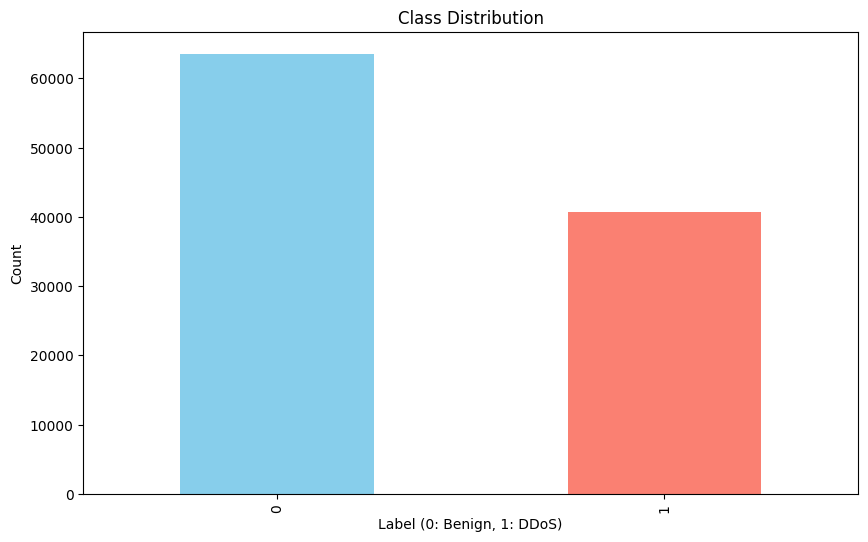

In [7]:
# Here we manually make a plot to show the class distribution
plt.figure(figsize=(10, 6)) # size of the plot
df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon']) # bar plot
plt.title('Class Distribution') # title of the plot
plt.xlabel('Label (0: Benign, 1: DDoS)') 
plt.ylabel('Count') 
plt.show()

Feature Selection

In [8]:
features = [
    'pktcount', 'bytecount', 'dur', 'tot_dur', 'flows', 
    'packetins', 'pktperflow', 'byteperflow', 'pktrate', 
    'Pairflow', 'port_no', 'tx_bytes', 'rx_bytes', 
    'tx_kbps', 'rx_kbps', 'tot_kbps'
]

#-***-
<!-- def process_ip_address(ip_series):
    """Process IP addresses into meaningful features."""
    processed = pd.DataFrame()
    
    # Extract IP features
    processed['ip_first_octet'] = ip_series.apply(lambda x: int(x.split('.')[0]))
    
    # Identify private IPs
    processed['is_private'] = ip_series.apply(
        lambda x: 1 if ipaddress.ip_address(x).is_private else 0
    )
    
    # Get IP class (A, B, C, D, E)
    def get_ip_class(first_octet):
        if first_octet < 128:
            return 0  # Class A
        elif first_octet < 192:
            return 1  # Class B
        elif first_octet < 224:
            return 2  # Class C
        elif first_octet < 240:
            return 3  # Class D
        else:
            return 4  # Class E
    
    processed['ip_class'] = processed['ip_first_octet'].apply(get_ip_class)
    
    return processed

def create_feature_set(df):
    """Create complete feature set including categorical and numeric features."""
    # Numeric features
    numeric_features = [
        'pktcount', 'bytecount', 'dur', 'tot_dur', 'flows', 
        'packetins', 'pktperflow', 'byteperflow', 'pktrate', 
        'Pairflow', 'port_no', 'tx_bytes', 'rx_bytes', 
        'tx_kbps', 'rx_kbps', 'tot_kbps'
    ]
    
    # Process Protocol (categorical)
    protocol_encoded = pd.get_dummies(df['Protocol'], prefix='protocol')
    
    # Process IP addresses
    src_features = process_ip_address(df['src'])
    src_features = src_features.add_prefix('src_')
    
    dst_features = process_ip_address(df['dst'])
    dst_features = dst_features.add_prefix('dst_')
    
    # Combine all features
    feature_set = pd.concat([
        df[numeric_features],
        protocol_encoded,
        src_features,
        dst_features
    ], axis=1)
    
    return feature_set -->

In [ ]:
#-***-

# x = create_feature_set(df)
# y = df['label']

# # Print feature information
# print("Final feature set shape:", x.shape)
# print("\nFeature names:")
# print(x.columns.tolist())

In [9]:
# Prepare x and y
x = df[features]
y = df['label']

In [10]:
# Handle missing values
imputer = SimpleImputer(strategy='mean') # impute missing values with the mean of the column
x = pd.DataFrame(imputer.fit_transform(x), columns=x.columns)

print(x.isnull().sum()) # check if there are any missing values left

pktcount       0
bytecount      0
dur            0
tot_dur        0
flows          0
packetins      0
pktperflow     0
byteperflow    0
pktrate        0
Pairflow       0
port_no        0
tx_bytes       0
rx_bytes       0
tx_kbps        0
rx_kbps        0
tot_kbps       0
dtype: int64


In [11]:
# Split the data into training and testing sets (with keeping stratification in mind for a balanced class distribution)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, # x - features, y - labels
    test_size=0.2,  # 80% training, 20% testing
    random_state=42, # seed for reproducibility
    stratify=y # keep the class distribution balanced in the training and testing sets (as seen above we have an unbalanced class distribution)
    )

Feature Scaling

In [ ]:
# We use standardization for scaling the numerical features in a range to ease the training process
scaler = StandardScaler() # standardization of the data
x_train_scaled = scaler.fit_transform(x_train) 
x_test_scaled = scaler.transform(x_test) 

# The models we used standartizaiton becasue it's strongly recommended for SVM and Logistic Regression

In [17]:
# custom scorer to focus on recall
def custom_scorer(y_true, y_pred):
    # give more importance to recall
    recall = recall_score(y_true, y_pred, average='binary')
    precision = average_precision_score(y_true, y_pred)                             
     # Weighted combination favoring recall (0.7 weight to recall)
    return 0.7 * recall + 0.3 * precision

Model Training And Evalutaion

In [18]:
# # custom scoring function for the F1 score (as we have an unbalanced class distribution)
# def balanced_f1(y_true, y_pred): # y_true - true labels / y_pred - predicted labels
#     return f1_score(y_true, y_pred, average='weighted')

In [20]:
# Setting up the models and their hyperparameters
# Addin hyperparameter optimization to the models NOTE: these aren't NN so we do not use epochs, batch size, etc. 

# 1. Random Forest with grid search
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', {0: 1, 1: 2}]  # Giving more weight to attacks
}


rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42), # random forest classifier
    rf_params, # parameters to optimize
    cv=3, # 3-fold cross-validation
    #scoring='f1',
    scoring=make_scorer(custom_scorer),
    n_jobs=-1 # use all available cores
)

print("\nTraining Random Forest...")
rf_grid.fit(x_train_scaled, y_train)
print("Best Random Forest parameters:", rf_grid.best_params_)

# 2. Support Vector Machine with grid search
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'],
    'class_weight': ['balanced', {0: 1, 1: 2}]  # Giving more weight to attacks
}


svm_grid = GridSearchCV(
    SVC(random_state=42, probability=True), # support vector machine classifier
    svm_params, # parameters to optimize
    cv=3, # 3-fold cross-validation
    #scoring='f1',
    scoring=make_scorer(custom_scorer),
    n_jobs=-1 # use all available cores
)

print("\nTraining SVM...")
svm_grid.fit(x_train_scaled, y_train)
print("Best SVM parameters:", svm_grid.best_params_)

# 3. Logistic Regression with grid search
lr_params = {
    'C': [0.1, 1, 10],
    'class_weight': ['balanced', {0: 1, 1: 2}],  # Giving more weight to attacks
    'max_iter': [1000]
}

lr_grid = GridSearchCV(
    LogisticRegression(random_state=42), 
    lr_params,
    cv=3, 
    #scoring='f1',
    scoring=make_scorer(custom_scorer),
    n_jobs=-1 
)

print("\nTraining Logistic Regression...")
lr_grid.fit(x_train_scaled, y_train)
print("Best Logistic Regression parameters:", lr_grid.best_params_)



Training Random Forest...
Best Random Forest parameters: {'class_weight': {0: 1, 1: 2}, 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}

Training SVM...
Best SVM parameters: {'C': 10, 'class_weight': {0: 1, 1: 2}, 'kernel': 'rbf'}

Training Logistic Regression...
Best Logistic Regression parameters: {'C': 1, 'class_weight': {0: 1, 1: 2}, 'max_iter': 1000}


In [21]:
traditional_models = {
    'Random Forest': rf_grid.best_estimator_,
    'Support Vector Machine': svm_grid.best_estimator_,
    'Logistic Regression': lr_grid.best_estimator_
}

In [22]:
# Addin NN
class DDoSDataset(Dataset): # custom dataset class
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
         
    def __len__(self):  
        return len(self.X)
    
    def __getitem__(self, idx): 
        return self.X[idx], self.y[idx]

class DDoSClassifier(nn.Module): # custom neural network class
    def __init__(self, input_size):
        super(DDoSClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 2)
        )
    
    def forward(self, x):
        return self.model(x)

Neural Network Training

In [26]:
# Hyperparameter grid for neural network
nn_params = {
    'learning_rate': [0.001, 0.0001],
    'batch_size': [32, 64],
    'hidden_size': [64, 128]
}

best_nn_score = 0
best_nn_params = {}
best_model_state = None

# Grid search for neural network
for lr in nn_params['learning_rate']:
    for batch_size in nn_params['batch_size']:
        for hidden_size in nn_params['hidden_size']:
            print(f"\nTrying params: lr={lr}, batch_size={batch_size}, hidden_size={hidden_size}")
            
            # Prepare data loaders
            train_dataset = DDoSDataset(x_train_scaled, y_train.values)
            test_dataset = DDoSDataset(x_test_scaled, y_test.values)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
            
            # Initialize model
            model = DDoSClassifier(len(features)).to(device)
            
            # Loss and optimizer
            criterion = nn.CrossEntropyLoss(
                weight=torch.tensor([1.0, 2.0]).to(device)
            )
            optimizer = optim.Adam(model.parameters(), lr=lr)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='max', factor=0.1, patience=5
            )
            
            # Training loop
            best_epoch_recall = 0
            
            for epoch in range(30):
                model.train()
                total_loss = 0
                
                for batch_X, batch_y in train_loader:
                    batch_X = batch_X.to(device)
                    batch_y = batch_y.to(device)
                    
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    
                    optimizer.zero_grad()
                    loss.backward() 
                    optimizer.step()
                    
                    total_loss += loss.item()
                
                # Validation
                model.eval()
                val_preds = []
                val_true = []
                
                with torch.no_grad():
                    for batch_X, batch_y in test_loader:
                        batch_X = batch_X.to(device)
                        outputs = model(batch_X)
                        _, predicted = torch.max(outputs, 1)
                        val_preds.extend(predicted.cpu().numpy())
                        val_true.extend(batch_y.numpy())
                
                epoch_recall = recall_score(val_true, val_preds)
                
                if epoch_recall > best_epoch_recall:
                    best_epoch_recall = epoch_recall
                    if epoch_recall > best_nn_score:
                        best_nn_score = epoch_recall
                        best_nn_params = {
                            'learning_rate': lr,
                            'batch_size': batch_size,
                            'hidden_size': hidden_size
                        }
                        best_model_state = model.state_dict()
                
                print(f"Epoch {epoch+1}/30, Loss: {total_loss/len(train_loader):.4f}, Recall: {epoch_recall:.4f}")

print("\nBest Neural Network parameters:", best_nn_params)
print("Best Recall Score:", best_nn_score)

# Load best model
final_model = DDoSClassifier(len(features)).to(device)
final_model.load_state_dict(best_model_state)


Trying params: lr=0.001, batch_size=32, hidden_size=64
Epoch 1/30, Loss: 0.1798, Recall: 0.9757
Epoch 2/30, Loss: 0.1159, Recall: 0.9898
Epoch 3/30, Loss: 0.0977, Recall: 0.9908
Epoch 4/30, Loss: 0.0867, Recall: 0.9903
Epoch 5/30, Loss: 0.0786, Recall: 0.9952
Epoch 6/30, Loss: 0.0728, Recall: 0.9855
Epoch 7/30, Loss: 0.0723, Recall: 0.9871
Epoch 8/30, Loss: 0.0694, Recall: 0.9877
Epoch 9/30, Loss: 0.0642, Recall: 0.9953
Epoch 10/30, Loss: 0.0654, Recall: 0.9941
Epoch 11/30, Loss: 0.0613, Recall: 0.9873
Epoch 12/30, Loss: 0.0607, Recall: 0.9946
Epoch 13/30, Loss: 0.0579, Recall: 0.9958
Epoch 14/30, Loss: 0.0574, Recall: 0.9925
Epoch 15/30, Loss: 0.0564, Recall: 0.9956
Epoch 16/30, Loss: 0.0565, Recall: 0.9960
Epoch 17/30, Loss: 0.0523, Recall: 0.9912
Epoch 18/30, Loss: 0.0533, Recall: 0.9967
Epoch 19/30, Loss: 0.0538, Recall: 0.9866
Epoch 20/30, Loss: 0.0529, Recall: 0.9934
Epoch 21/30, Loss: 0.0499, Recall: 0.9931
Epoch 22/30, Loss: 0.0495, Recall: 0.9984
Epoch 23/30, Loss: 0.0478, Re

<All keys matched successfully>

In [27]:
# Evaluate each model
def evaluate_model(name, y_true, y_pred, y_scores=None):
    print(f"\n{name} Results:")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    recall = recall_score(y_true, y_pred)
    precision = average_precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        'recall': recall,
        'precision': precision,
        'f1': f1
    }






Random Forest Results:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12712
           1       1.00      1.00      1.00      8157

    accuracy                           1.00     20869
   macro avg       1.00      1.00      1.00     20869
weighted avg       1.00      1.00      1.00     20869



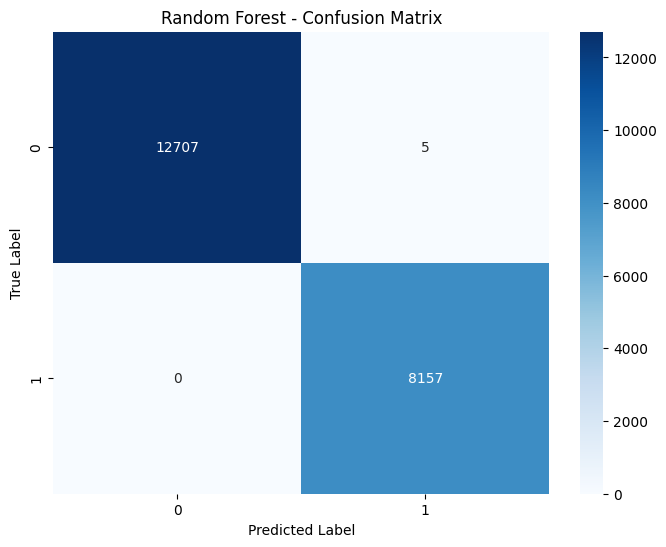


Support Vector Machine Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     12712
           1       0.95      0.99      0.97      8157

    accuracy                           0.97     20869
   macro avg       0.97      0.98      0.97     20869
weighted avg       0.98      0.97      0.97     20869



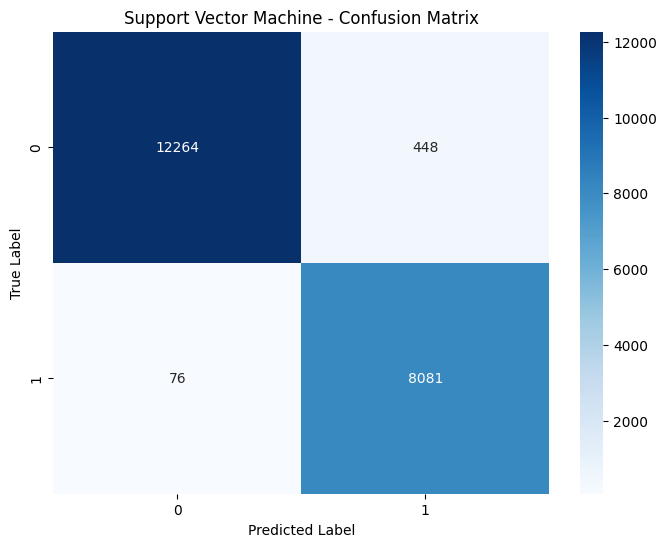


Logistic Regression Results:

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.67      0.75     12712
           1       0.61      0.82      0.70      8157

    accuracy                           0.73     20869
   macro avg       0.73      0.74      0.72     20869
weighted avg       0.76      0.73      0.73     20869



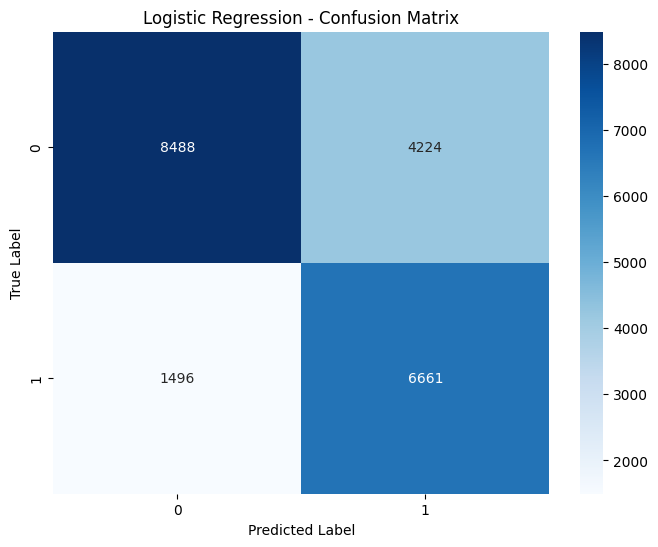


Neural Network Results:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     12712
           1       0.97      0.99      0.98      8157

    accuracy                           0.99     20869
   macro avg       0.98      0.99      0.99     20869
weighted avg       0.99      0.99      0.99     20869



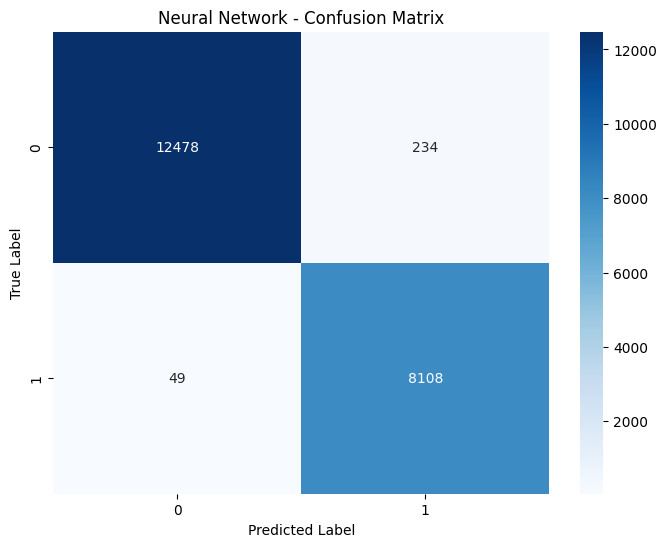

In [29]:
# Evaluate All Models
results = {}

# Evaluate traditional models
for name, model in traditional_models.items():
    y_pred = model.predict(x_test_scaled)
    y_scores = model.predict_proba(x_test_scaled)[:, 1]
    results[name] = evaluate_model(name, y_test.to_numpy(), y_pred, y_scores)

# Evaluate neural network
final_model.eval()
y_pred_nn = []
y_scores_nn = []

with torch.no_grad():
    test_dataset = DDoSDataset(x_test_scaled, y_test.to_numpy())
    test_loader = DataLoader(test_dataset, batch_size=64)
    
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = final_model(batch_X)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_pred_nn.extend(predicted.cpu().numpy())
        y_scores_nn.extend(probabilities[:, 1].cpu().numpy())

results['Neural Network'] = evaluate_model(
    'Neural Network', 
    y_test.to_numpy(), 
    y_pred_nn, 
    y_scores_nn
)

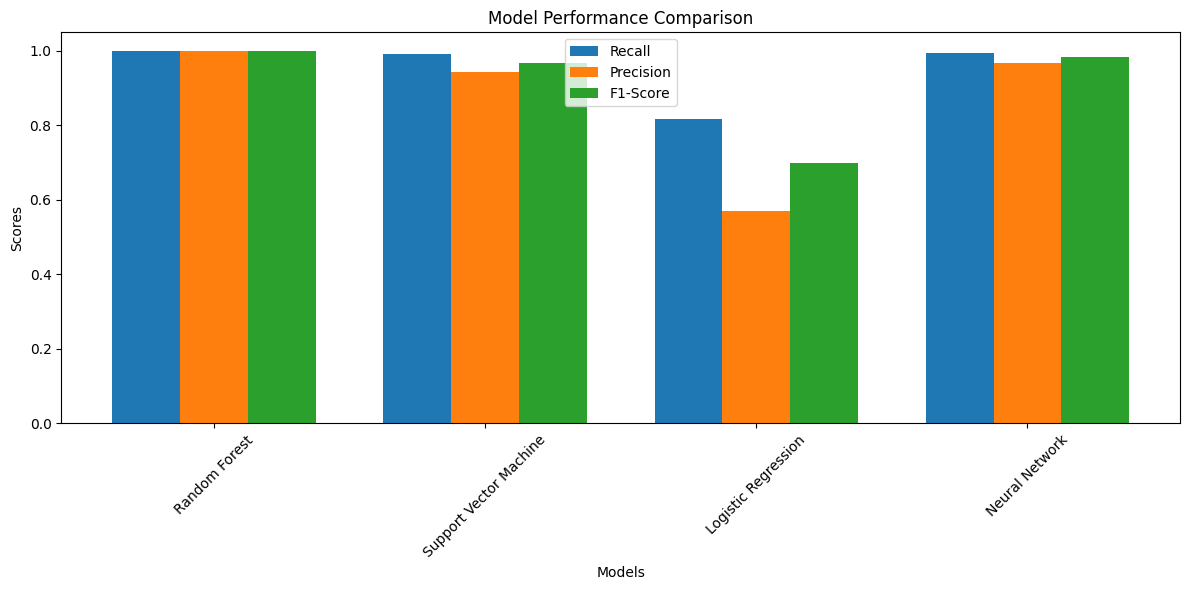

In [30]:
# Visualize Results
plt.figure(figsize=(12, 6))
models = list(results.keys())
recalls = [results[m]['recall'] for m in models]
precisions = [results[m]['precision'] for m in models]
f1_scores = [results[m]['f1'] for m in models]

x = np.arange(len(models))
width = 0.25

plt.bar(x - width, recalls, width, label='Recall')
plt.bar(x, precisions, width, label='Precision')
plt.bar(x + width, f1_scores, width, label='F1-Score')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(x, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

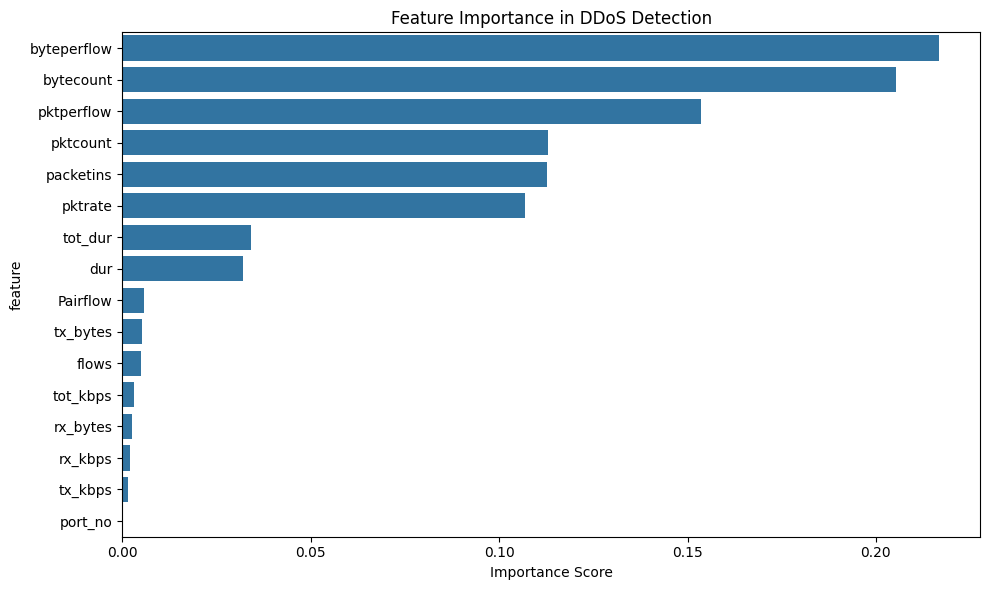

In [31]:
# Feature Importance (for Random Forest)

if hasattr(rf_grid.best_estimator_, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': rf_grid.best_estimator_.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance in DDoS Detection')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()